In [1]:
# %matplotlib widget
import os
import numpy as np
import h5py

tissue_type_EV = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
tissue_type_IV = 1 
oxy_level = [78, 85]
results_dir = './outputs/'

def read_results(filename):
    signal_magnitude_IV = []       
    signal_magnitude_EV = [] 
    filepath = os.path.join(results_dir, f'{filename}.h5')
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])                
        S = np.array(h5['scales'])  
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type_EV)
            M_f = M[ids, mask, 0, :]             
            M_f = np.sum(M_f[...,0:2], axis=0)            
            signal_magnitude_EV.append(np.linalg.norm(M_f))   

            mask = (T[ids, :, 0, 0] == tissue_type_IV)
            M_f = M[ids, mask, 0, :]             
            M_f = np.sum(M_f[...,0:2], axis=0)            
            signal_magnitude_IV.append(np.linalg.norm(M_f)) 
            # if np.count_nonzero(signal_magnitude_IV[-1]==0) > 0:
            #     print(filename, s)

    return signal_magnitude_IV, signal_magnitude_EV

############
radius = 8
filename_78 = ['gre_78_impermeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'se_78_impermeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'bssfp_78_impermeable_r8_Y0.0_BVF4_ori90_fov600_res1200',
               'gre_78_permeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'se_78_permeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'bssfp_78_permeable_r8_Y0.0_BVF4_ori90_fov600_res1200']
filename_85 = ['gre_85_impermeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'se_85_impermeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'bssfp_85_impermeable_r8_Y0.0_BVF4_ori90_fov600_res1200',
               'gre_85_permeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'se_85_permeable_r8_Y0.0_BVF4_ori90_fov600_res1200', 'bssfp_85_permeable_r8_Y0.0_BVF4_ori90_fov600_res1200']

signal_78 = []
for idf, f in enumerate(filename_78):
    signal_78.append(read_results(f))
signal_85 = []
for idf, f in enumerate(filename_85):
    signal_85.append(read_results(f))    

signal_78 = np.array(signal_78)
signal_85 = np.array(signal_85)

print(np.count_nonzero(signal_78==0), np.count_nonzero(signal_85==0))
signal_78[signal_78 == 0] = 'nan'
signal_85[signal_85 == 0] = 'nan'

print(signal_85.shape)
signal_change = 100 * (1 - signal_78 / signal_85)

with h5py.File(os.path.join(results_dir, f'{f}.h5'), 'r') as h5:
    scales = np.array(h5['scales']) 

# save as mat file
import scipy.io as sio
sio.savemat(os.path.join(results_dir, 'signal_change.mat'), {'radius':radius, 'scales':scales, 'signal_change': signal_change})


74 74
(6, 2, 50)


In [2]:
# load mat file
import os
import numpy as np
import scipy.io as sio
results_dir = './outputs/'
data = sio.loadmat(os.path.join(results_dir, 'signal_change.mat'))
signal_change = np.array(data['signal_change'])
scales = data['scales']
radius = data['radius']
print(signal_change.shape)


(6, 2, 50)


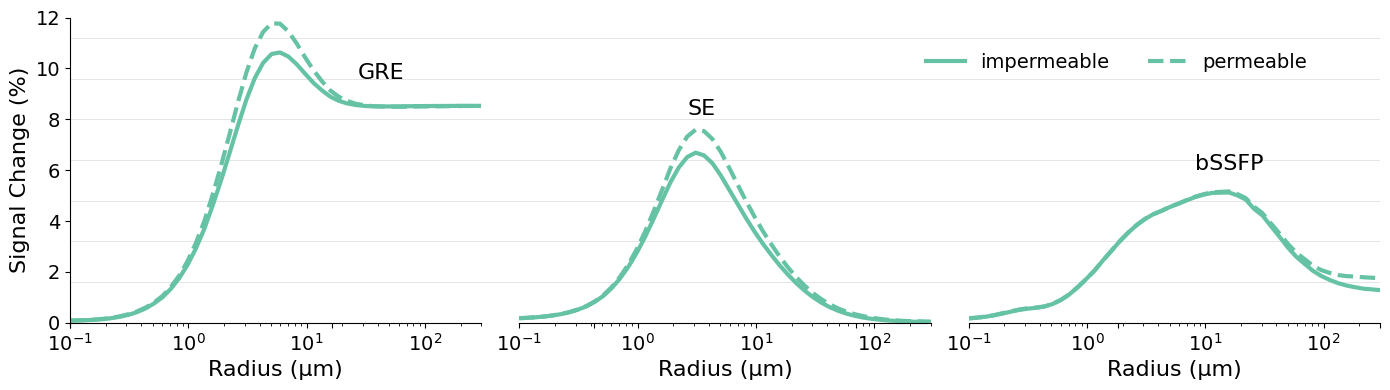

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

# Create data
x = radius * scales.squeeze()
x = x.reshape(-1)

# Create a figure and a 3D axis
plt.close('all')

cmap = plt.get_cmap('Set2')
colors = cmap(np.linspace(0, 1, len(signal_change)))
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].plot(x, signal_change[0, 1, :], color=colors[0], label='impermeable', linewidth=3)
axs[0].plot(x, signal_change[3, 1, :], '--',color=colors[0], label='permeable', linewidth=3)

axs[1].plot(x, signal_change[1, 1, :], color=colors[0], linewidth=3)
axs[1].plot(x, signal_change[4, 1, :], '--',color=colors[0], linewidth=3)

axs[2].plot(x, signal_change[2, 1, :], color=colors[0], linewidth=3)
axs[2].plot(x, signal_change[5, 1, :], '--', color=colors[0], linewidth=3)

for i, ax in enumerate(axs):
    ax.set_xlabel('Radius (µm)', fontsize=16)   
    ax.set_xscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0.1, 300])
    ax.set_ylim([0, 12])
    ax.patch.set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)

    if i == 0:
        ax.set_ylabel('Signal Change (%)', fontsize=16)
        ax.text(0.7, 0.8, 'GRE', transform=ax.transAxes, fontsize=16)
    if i == 1:
        ax.text(0.41, 0.68, 'SE', transform=ax.transAxes, fontsize=16)
    if i == 2:
        ax.text(0.55, 0.5, 'bSSFP', transform=ax.transAxes, fontsize=16)
    if i != 0:
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', left=False)

ax_g = fig.add_subplot(111, zorder=-1)
ax_g.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax_g.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
ax_g.set_ylim([0, 15])
ax_g.yaxis.grid(True, linewidth=0.7, color='#e5e5e5')
ax_g.patch.set_visible(False)

# fig.patch.set_visible(False)
fig.legend(bbox_to_anchor=(.95, .9), ncols=2, frameon=False,  fontsize=14, title_fontsize=14)

fig.tight_layout()
# plt.savefig('./figures/permeability.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig('../figures_pdf/permeability.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()